# Advanced ML

### Understanding Markov Chain Monte Carlo (MCMC) and Metropolis Sampler

Reference: https://twiecki.io/blog/2015/11/10/mcmc-sampling/

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.color_palette("Paired")
sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

Lets generate some data: 20 points from a normal centered around zero. Our goal will be to estimate the posterior of the mean mu. We'll assume that we know the standard deviation to be 1.

In [2]:
data = np.random.randn(20)

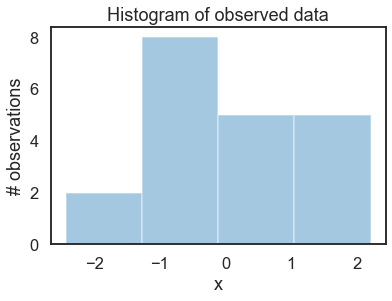

In [3]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

## Posterior Probability

In this simple case, we will assume that this data is normal distributed, i.e. the likelihood of the model is normal.

For simplicity, we'll assume we know that σ=1 and we'll want to infer the posterior for μ. 

For each parameter we want to infer, we have to chose a prior. For simplicity, lets also assume a Normal distribution as a prior for μ. 

$$ \mu \sim \text{Normal}(0, 1) $$
$$ x|\mu \sim \text{Normal}(x; \mu, 1)$$

What is convenient, is that for this model, we actually can compute the posterior analytically. That's because for a normal likelihood with known standard deviation, the normal prior for μ is conjugate (posterior will follow the same distribution as the prior), so we know that our posterior for μ is also normal. 

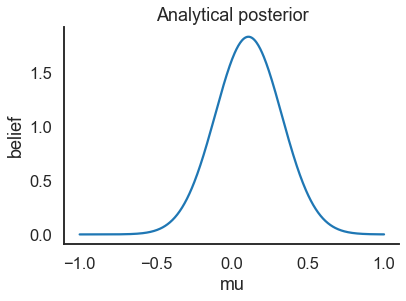

In [4]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

This shows our quantity of interest, the probability of μ's values after having seen the data, taking our prior information into account. 

## MCMC
Lets assume, however, that our prior wasn't conjugate and we couldn't solve this by hand which is usually the case.

Steps:

1. Find starting parameter position 
    - This can be randomly chosen so set to an arbitrary value

2. Propose to move (jump) from that position somewhere else :
    - This is Markov aspect of MCMC
    - The Metropolis sampler is very dumb and just takes a sample from a normal distribution (no relationship to the normal we assume for the model) centered around your current mu value (i.e. mu_current) with a certain standard deviation (proposal_width) that will determine how far you propose jumps

3. Evaluate the likelihood of the proposed parameter:
    - Check if the resulting normal distribution with that proposed μ explaines the data better than your old μ. Accept the jump if the mu_proposal has higher likelihood than mu_current with some probability/stochasticity. So we'll also have to sometimes accept moves into the other direction
    - We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed mu and a fixed sigma = 1). This can easily be computed by calculating the probability for each data point using `scipy.stats.normal(mu, sigma).pdf(data)` and then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities but we omit this here)
    - p_accept = p_proposal / p_current  => Dividing the posterior of proposed parameter setting by the posterior of the current parameter setting, P(x) -- the quantity we can't compute -- gets canceled out. We're actually dividing the full posterior at one position by the full posterior at another position. That way, we are visiting regions of high posterior probability relatively more often than those of low posterior probability.
    
    $$\frac{\frac{P(x|\mu) P(\mu)}{P(x)}}{\frac{P(x|\mu_0) P(\mu_0)}{P(x)}} = \frac{P(x|\mu) P(\mu)}{P(x|\mu_0) P(\mu_0)}$$

In [5]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

## Visualizing MCMC

- 1st column (Prior distribution): 
    - what our belief about μ is before seeing the data. The vertical lines represent our current μ in blue and our proposed μ in either red or green (rejected or accepted, respectively).

- 2nd column (likelihood): 
    - What we are using to evaluate how good our model explains the data. You can see that the likelihood function changes in response to the proposed μ. The blue histogram which is our data. The solid line in green or red is the likelihood with the currently proposed mu. Intuitively, the more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dotted line of the same color is the proposed mu and the dotted blue line is the current mu.

- 3rd column (Posterior distribution): 
    - Here we are displaying the normalized posterior but as we found out above, we can just multiply the prior value for the current and proposed μ's by the likelihood value for the two μ's to get the unnormalized posterior values (which we use for the actual computation), and divide one by the other to get our acceptance probability.

- 4th column (Trace): 
    - For the posterior samples of μ we're generating, we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

In [6]:
# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

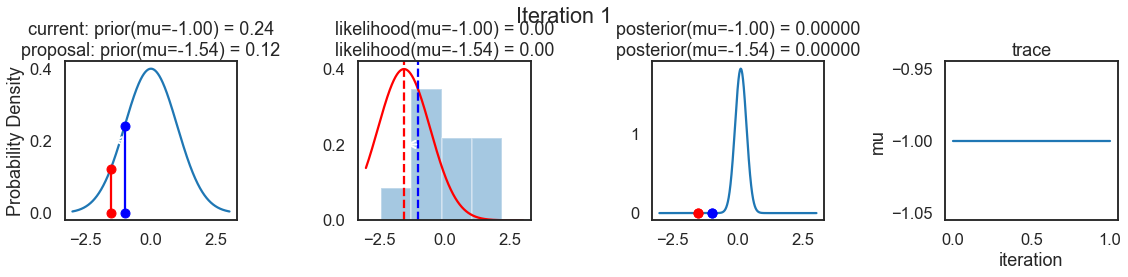

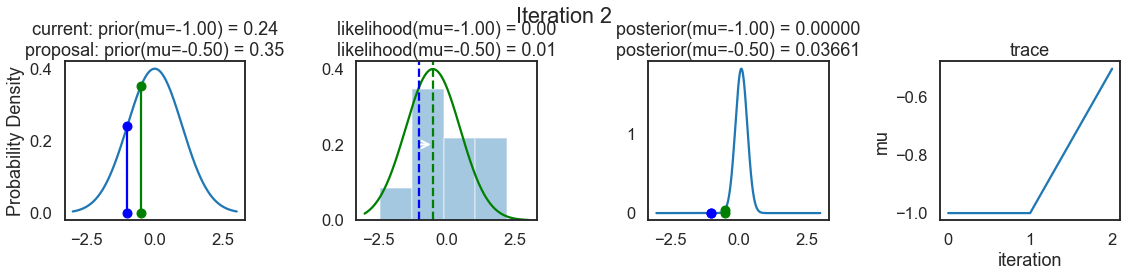

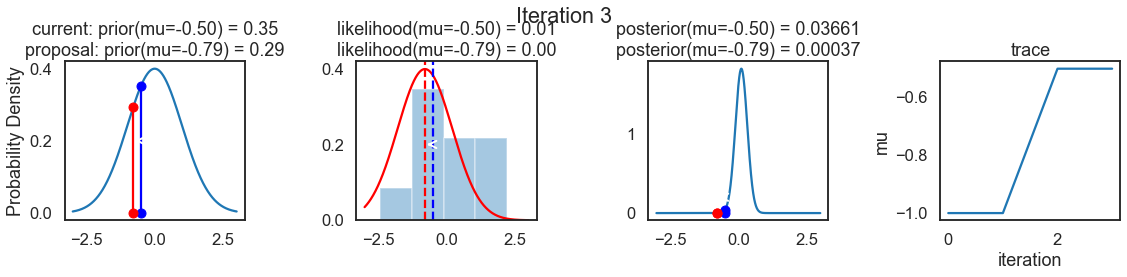

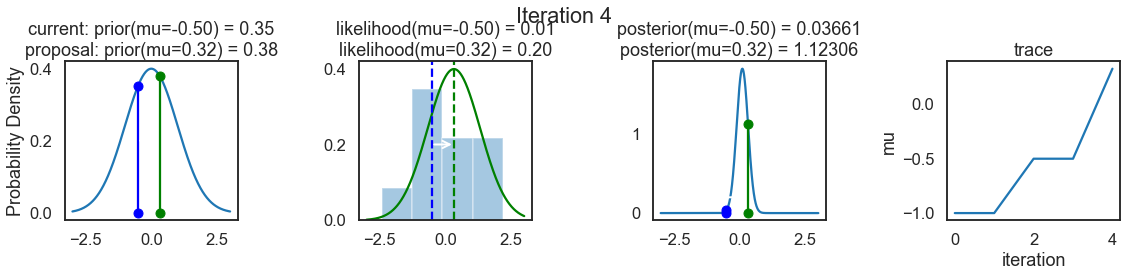

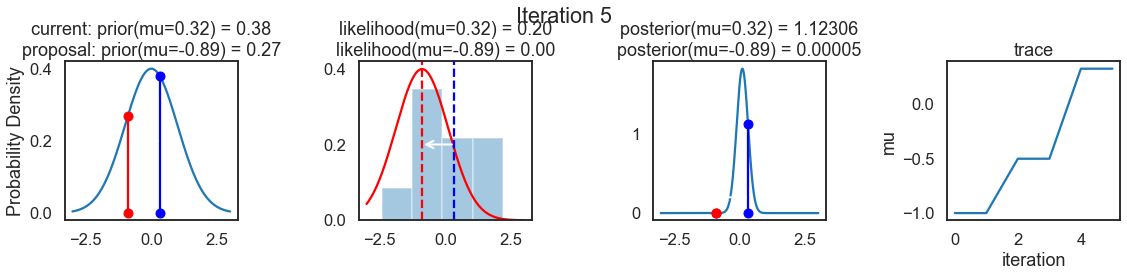

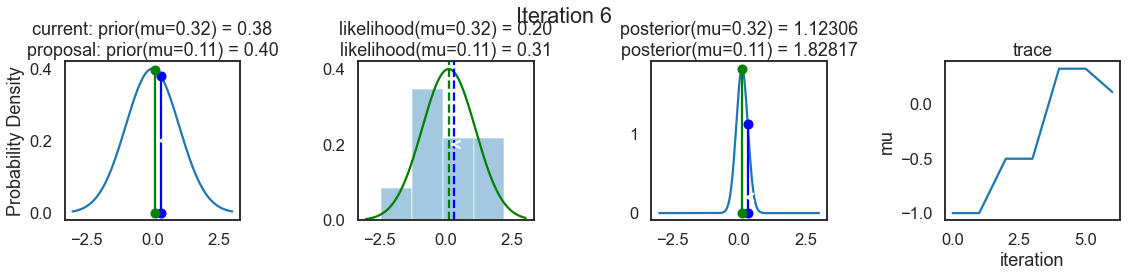

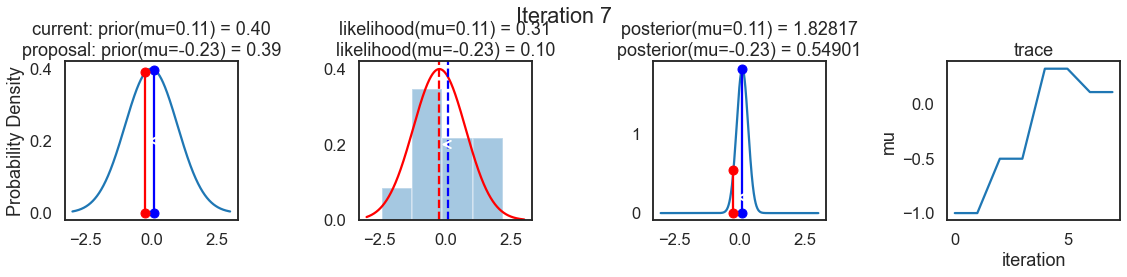

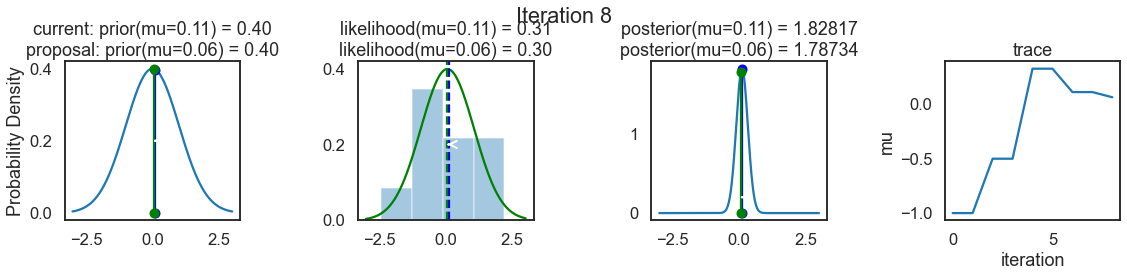

In [7]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

## Plot Posterior 

This is usually called the trace. 

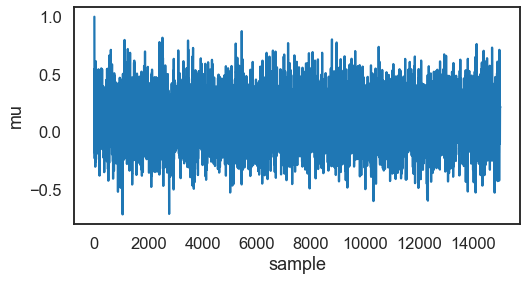

In [8]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

To now get an approximation of the posterior (the reason why we're doing all this), we simply take the histogram of this trace. It's important to keep in mind that although this looks similar to the data we sampled above to fit the model, the two are completely separate. The below plot represents our belief in mu. In this case it just happens to also be normal but for a different model, it could have a completely different shape than the likelihood or prior.

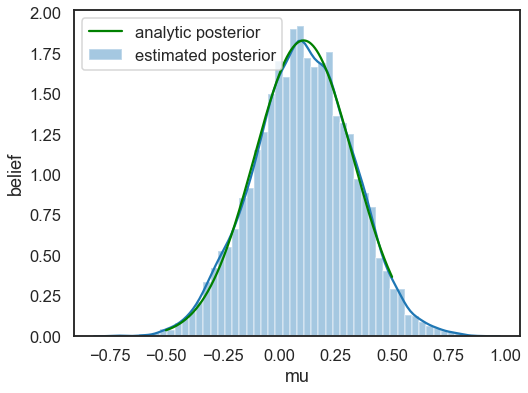

In [10]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

### Proposal Width 

Above we set the proposal width to 0.5 which is good. In general if the width is too narrow sampling will be inefficient and could take a long time to explore the whole parameter space, and shows the typical random-walk behavior. If the width is too large the parameter jump will not be accepted.

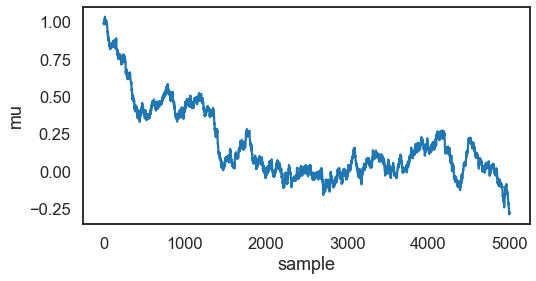

In [11]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

<Figure size 576x288 with 0 Axes>

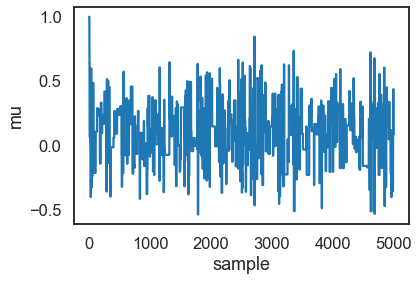

In [12]:
#large proposal_width
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

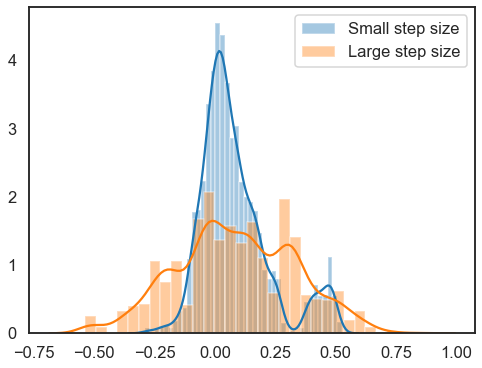

In [13]:
plt.figure(figsize=(8,6))
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

## PyMC API

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\apps\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 62000/62000 [00:26<00:00, 2316.84draws/s]
The number of effective samples is smaller than 25% for some parameters.


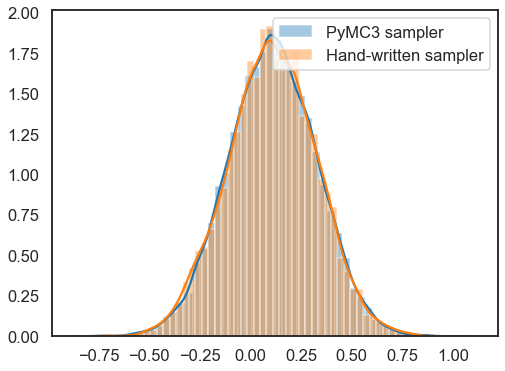

In [14]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)

plt.figure(figsize=(8,6))
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();